# This notebook is analzying the spectral parameters from the frontal EEG channels pre and post MST.

We are only including frontal because we are basing our analyses off of Smith, 2022, in which their dataset only uses fronto-central channels. Additionally, the treatment is targeted to frontal/central areas.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import scipy
from statsmodels.formula.api import ols
from scipy.stats import ttest_rel
from pingouin import ttest, normality, wilcoxon

from mst_plotting_functions import plot_feature_prepost
from matplotlib import rcParams
rcParams['font.family'] = 'Helvetica'

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.0, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
%matplotlib inline

### Functions

In [3]:
def perm_test(df, feature='', nreps=10000, seed=256, plot_hist=True, run_ttest=True):
    '''permutation test from https://www.uvm.edu/\~statdhtx/StatPages/\
    ResamplingWithR/RandomMatchedSample/RandomMatchedSampleR.html
    '''
    
    means_pre = df[df['pre_post']=='pre'][feature].values
    means_post = df[df['pre_post']=='post'][feature].values
    
    diff_obt = np.nanmedian(means_post) - np.nanmedian(means_pre)
    difference = means_post-means_pre
    
    np.random.seed(seed)
    resamp_mean_diff = np.zeros(nreps)

    for i in range(0, nreps):
        signs = np.random.choice([1, -1], len(difference), replace=True)
        resamp = difference * signs
        resamp_mean_diff[i] = np.nanmedian(resamp)

    diff_obt = abs(diff_obt)
    highprob = len(resamp_mean_diff[resamp_mean_diff >= diff_obt])/nreps
    lowprob = len(resamp_mean_diff[resamp_mean_diff <= -diff_obt])/nreps
    prob2tailed = lowprob + highprob

    print("The probability from the sampling statistics is = ",prob2tailed,'\n')

    if plot_hist:
        plt.hist(resamp_mean_diff, bins=30);
        plt.title(feature)
        plt.xlabel('Median Difference')
        plt.axvline(x=diff_obt, c='r')
        plt.axvline(x=-diff_obt, c='r')

    # compare to student's t-test
    if run_ttest:
        print(ttest(means_pre, means_post, paired=True))

In [4]:
FRONTAL_ONLY = True

In [5]:
# load dataframe
exp_df = pd.read_csv('../saved_files_appeal/mst_files/mst_all_features.csv', index_col = 0)

# Exclude channels from ppn's with bad fits
exp_df_included = exp_df[exp_df['exclude']==False]


In [6]:
# frontal_channels = ['FP1', 'FPZ', 'FP2', 'AF3', 'AF4', 'F7', 'F5', 'F3', 'F1', 'FZ',
#                     'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FCZ', 'FC2',
#                     'FC4', 'FC6', 'FT8', 'C5', 'C3', 'C1', 'CZ', 'C2', 'C4', 'C6']

frontal_channels = ['FP1', 'FPZ', 'FP2', 'AF3', 'AF4', 'F7', 'F5', 'F3', 'F1', 'FZ',
                    'F2', 'F4', 'F6', 'F8', 'FC5', 'FC3', 'FC1', 'FCZ', 'FC2',
                    'FC4', 'FC6']

if FRONTAL_ONLY:
    exp_df_included = exp_df_included[exp_df_included['channel'].isin(frontal_channels)]
else:
    exp_df_included = exp_df

## Load SpecParam Fits

In [7]:
fits_pre = np.load('../saved_files_appeal/mst_files/mst_fits_pre.npy')
fits_post = np.load('../saved_files_appeal/mst_files/mst_fits_post.npy')
freq_axis = np.load('../saved_files_appeal/mst_files/mst_freq_axis.npy')

**Correct for excluded fits**

In [8]:
# get boolean area with True to exclude channels from patients
to_exclude_pre = exp_df['exclude'][exp_df['pre_post']=='pre'].values
to_exclude_post = exp_df['exclude'][exp_df['pre_post']=='post'].values

# reshape fits array from [23, 60,99] --> [1390, 99]
fits_pre_flat = fits_pre.reshape(len(to_exclude_pre), fits_pre.shape[2])
fits_post_flat = fits_post.reshape(len(to_exclude_pre), fits_pre.shape[2])

# replace to excluded ones with nans
fits_pre_flat[to_exclude_pre] = np.nan
fits_post_flat[to_exclude_post] = np.nan

# reshape back to original array from  [1390, 99] --> [23, 60,99]
fits_pre_included = fits_pre_flat.reshape(fits_pre.shape[0], fits_pre.shape[1], fits_pre.shape[2])
fits_post_included = fits_post_flat.reshape(fits_pre.shape[0], fits_pre.shape[1], fits_pre.shape[2])

## Load PSD's

In [9]:
psd_pre = np.load('../saved_files_appeal/mst_files/pre_mst_psd.npy')
psd_post = np.load('../saved_files_appeal/mst_files/post_mst_psd.npy')

**Correct for excluded PSD's**

In [10]:
# reshape psd array from [23, 60,99] --> [1390, 99]
psd_pre_flat = psd_pre.reshape(len(to_exclude_pre), psd_pre.shape[2])
psd_post_flat = psd_post.reshape(len(to_exclude_pre), psd_pre.shape[2])

# replace to excluded ones with nans
psd_pre_flat[to_exclude_pre] = np.nan
psd_post_flat[to_exclude_post] = np.nan

# reshape back to original array from  [1390, 99] --> [23, 60,99]
psd_pre_included = psd_pre_flat.reshape(psd_pre.shape[0], psd_pre.shape[1], psd_pre.shape[2])
psd_post_included = psd_post_flat.reshape(psd_pre.shape[0], psd_pre.shape[1], psd_pre.shape[2])

### Replace NaN's with 0's for oscillatory amplitude (aperiodic adjusted)

There are so few delta oscillations, that we cannot run statistics (later on) using delta_amp. Therefore, we want to put a value instead of a NaN, and say that no oscillation = 0 mV. 

We may not end up using this no nan dataframe, and simply use permutation testing instead, but keeping this here just in case.

In [11]:
df_include_nonan = exp_df_included.copy()
df_include_nonan['delta_amp'] = df_include_nonan['delta_amp'].fillna(0)
df_include_nonan['theta_amp'] = df_include_nonan['theta_amp'].fillna(0)
df_include_nonan['alpha_amp'] = df_include_nonan['alpha_amp'].fillna(0)
df_include_nonan

,patient,pre_post,channel,delta_cf,delta_bw,delta_amp,delta_bp,theta_cf,theta_bw,theta_amp,theta_bp,alpha_cf,alpha_bw,alpha_amp,alpha_bp,offset,exponent,error,r_squared,exclude
0,9,pre,FP1,NaN,NaN,0.0,-11.283243,6.160561,3.012282,0.722517,-11.315310,9.540913,2.163893,1.129194,-11.300131,-10.910216,1.385597,0.068730,0.981048,False
1,9,pre,FPZ,NaN,NaN,0.0,-11.311451,6.265365,3.086557,0.733975,-11.328971,9.583599,2.081748,1.151045,-11.294941,-10.944674,1.359475,0.069224,0.980534,False
2,9,pre,FP2,NaN,NaN,0.0,-11.285025,NaN,NaN,0.000000,-11.403185,8.828444,5.516757,0.979455,-11.320865,-10.902679,1.417495,0.073972,0.978797,False
3,9,pre,AF3,NaN,NaN,0.0,-11.235786,NaN,NaN,0.000000,-11.160861,10.032387,8.000000,0.986879,-11.267972,-10.919900,1.315336,0.129817,0.947035,False
4,9,pre,AF4,NaN,NaN,0.0,-11.277961,5.176093,1.263650,0.715413,-11.283006,8.727501,4.945225,0.997578,-11.301249,-10.889718,1.419578,0.071667,0.979583,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2717,191,post,FC1,NaN,NaN,0.0,-12.110455,NaN,NaN,0.000000,-12.215916,9.190795,3.505554,1.438309,-11.618953,-11.651782,1.252524,0.090567,0.972185,False
2718,191,post,FCZ,NaN,NaN,0.0,-12.074157,NaN,NaN,0.000000,-12.188564,9.095027,3.544203,1.405454,-11.609612,-11.631258,1.257385,0.103540,0.965291,False
2719,191,post,FC2,NaN,NaN,0.0,-12.084908,NaN,NaN,0.000000,-12.197249,9.114572,3.623394,1.382153,-11.601712,-11.666210,1.195875,0.090967,0.969700,False
2720,191,post,FC4,NaN,NaN,0.0,-12.044126,NaN,NaN,0.000000,-12.137175,8.696469,1.355187,1.555469,-11.527702,-11.577389,1.181892,0.062963,0.984063,False


## Averaging Over All (*Frontal*) Electrodes Per Subject

**Average over with amplitudes as 0 (i.e. exp_df_mean_nonan)**

In [12]:
# Take features of interest + average over all electrodes per patient
features = ['exponent', 'offset', 'delta_amp', 'delta_bp', 'theta_amp', 'theta_bp', 'theta_cf', 'delta_cf',
            'alpha_amp', 'alpha_bp', 'alpha_bw', 'alpha_cf']
exp_df_mean_nonan = pd.DataFrame(df_include_nonan.groupby(['patient', 'pre_post'], as_index=False)[features].mean())

**Average over with NaNs (i.e. exp_df_mean)**

In [13]:
# Take features of interest + average over all electrodes per patient
features = ['exponent', 'offset', 'delta_amp', 'delta_bp', 'theta_amp', 'theta_bp', 'theta_cf', 'delta_cf',
            'alpha_amp', 'alpha_bp', 'alpha_bw', 'alpha_cf']
exp_df_mean = pd.DataFrame(exp_df_included.groupby(['patient', 'pre_post'], as_index=False)[features].mean())

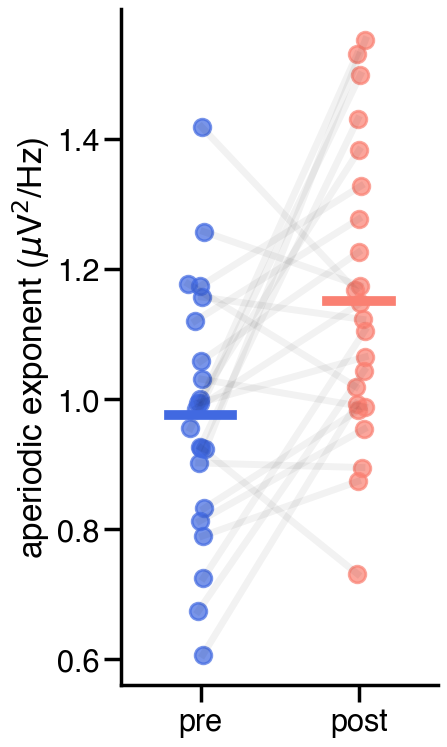

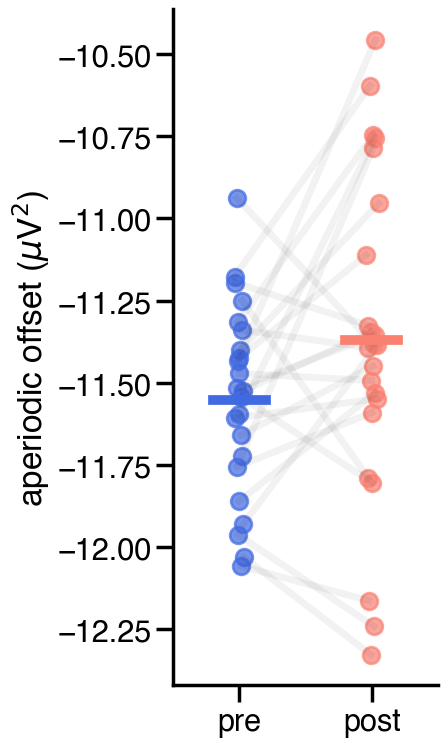

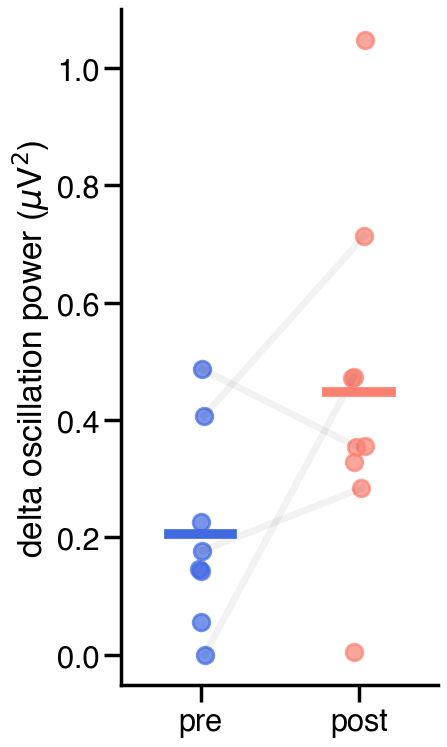

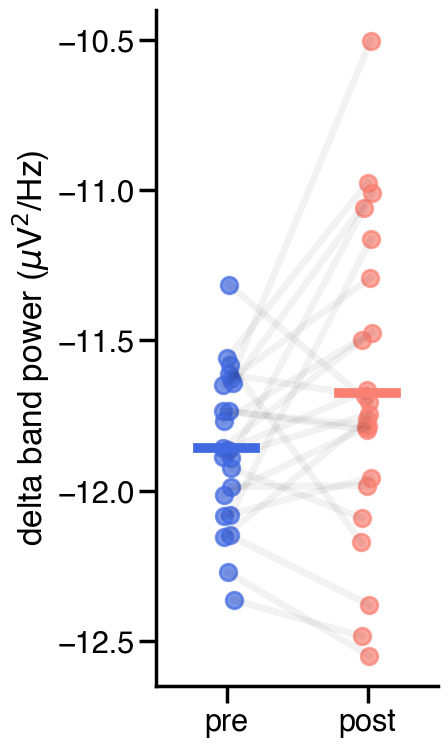

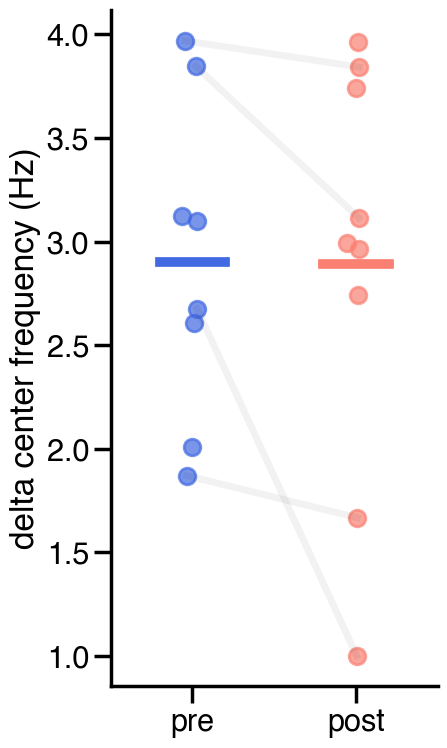

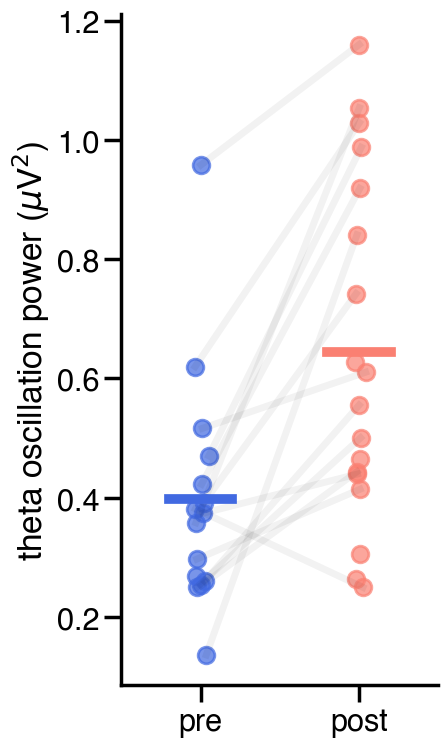

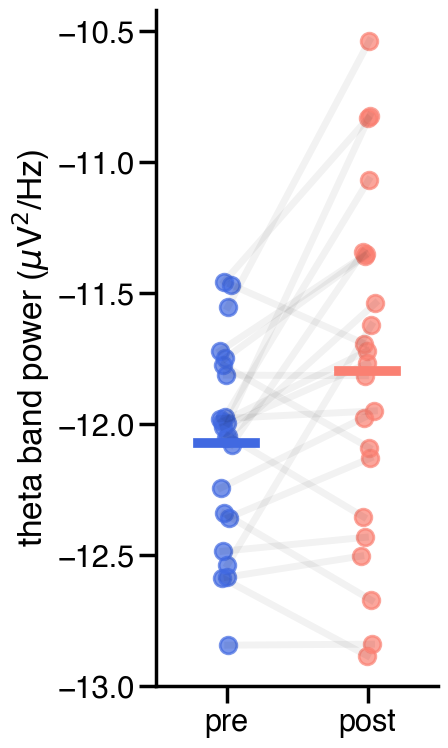

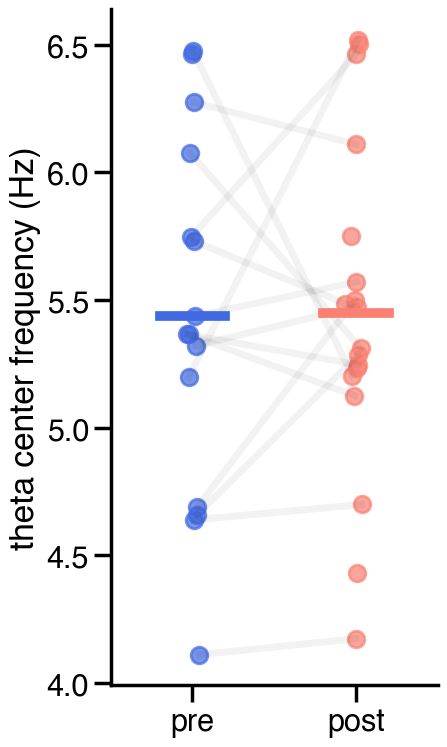

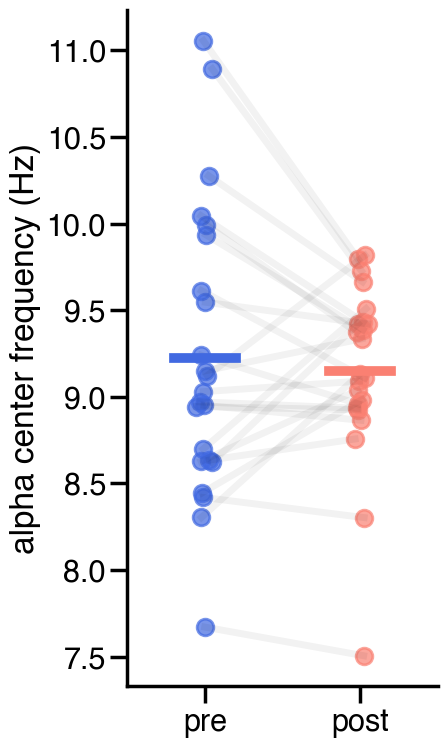

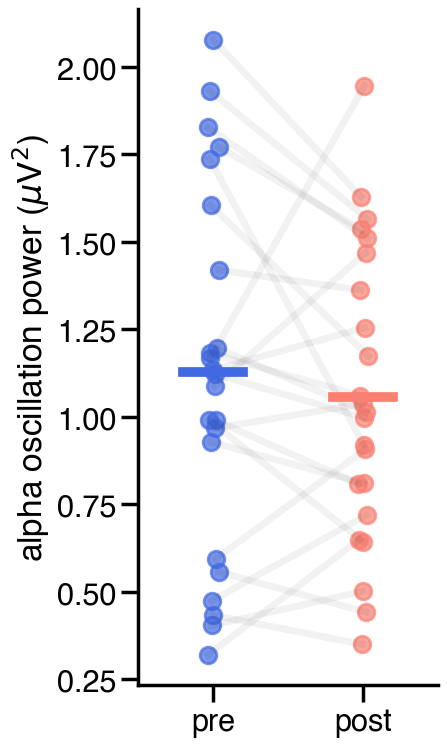

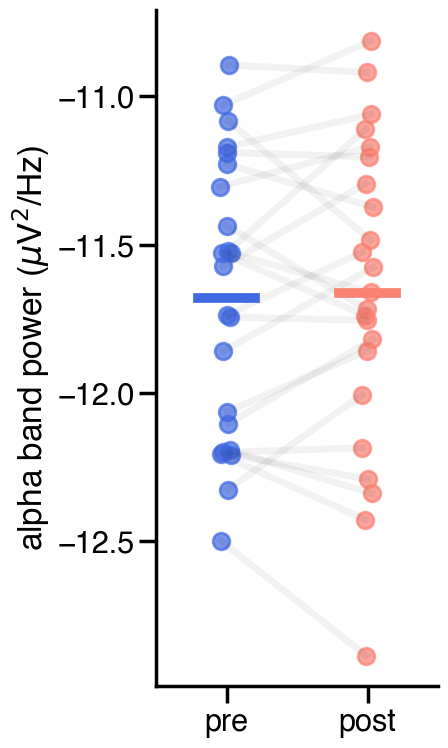

In [14]:
SAVE_FIG = False
fig_path = '../figures/'

# %matplotlib qt

features = ['exponent', 'offset', 'delta_amp', 'delta_bp', 'delta_cf', 'theta_amp', 'theta_bp', 'theta_cf',
            'alpha_cf', 'alpha_amp', 'alpha_bp']

labels = ['aperiodic exponent ($\mu$V$^2$/Hz)', 'aperiodic offset ($\mu$V$^2$)',
          'delta oscillation power ($\mu$V$^2$)', 'delta band power ($\mu$V$^2$/Hz)', 'delta center frequency (Hz)',
          'theta oscillation power ($\mu$V$^2$)', 'theta band power ($\mu$V$^2$/Hz)', 'theta center frequency (Hz)',
          'alpha center frequency (Hz)', 'alpha oscillation power ($\mu$V$^2$)', 'alpha band power ($\mu$V$^2$/Hz)' ]

for feature, label in zip(features, labels):
    plot_feature_prepost(exp_df_mean, feature=feature)
    plt.ylabel(label)
    sns.despine()
    plt.tight_layout()
    plt.show()
    
    if SAVE_FIG:
        plt.savefig(fig_path+feature+'.pdf', format='pdf')

### Figure-Specific Axes

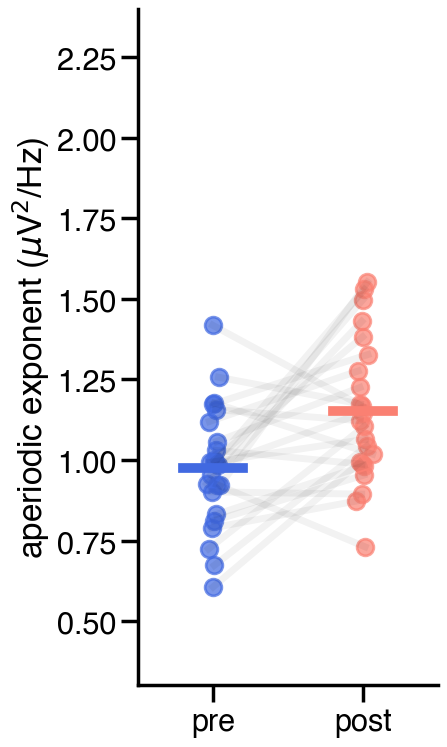

In [15]:
plot_feature_prepost(exp_df_mean, feature='exponent')
plt.ylabel('aperiodic exponent ($\mu$V$^2$/Hz)')
plt.ylim(0.3, 2.4)
sns.despine()
plt.tight_layout()
plt.show()

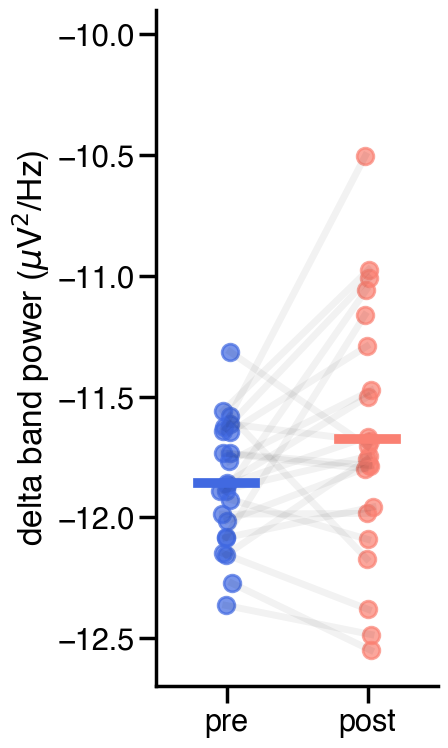

In [16]:
plot_feature_prepost(exp_df_mean, feature='delta_bp')
plt.ylabel('delta band power ($\mu$V$^2$/Hz)')
plt.ylim(-12.7, -9.9)
sns.despine()
plt.tight_layout()
plt.show()

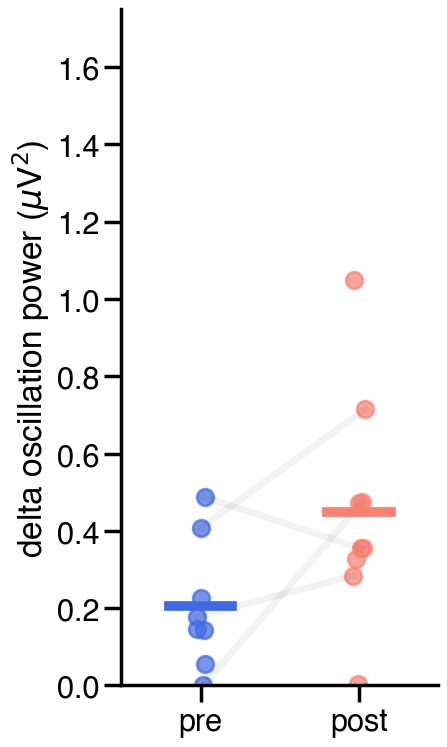

In [17]:
plot_feature_prepost(exp_df_mean, feature='delta_amp')
plt.ylabel('delta oscillation power ($\mu$V$^2$)')
plt.ylim(0, 1.75)
sns.despine()
plt.tight_layout()
plt.show()

## Plot Spectra

In [18]:
fits_pre_mean = np.nanmean(fits_pre_included, axis=1)
fits_post_mean = np.nanmean(fits_post_included, axis=1)

fits_pre_grand_mean = np.nanmean(fits_pre_included, axis=(0,1))
fits_post_grand_mean = np.nanmean(fits_post_included, axis=(0,1))

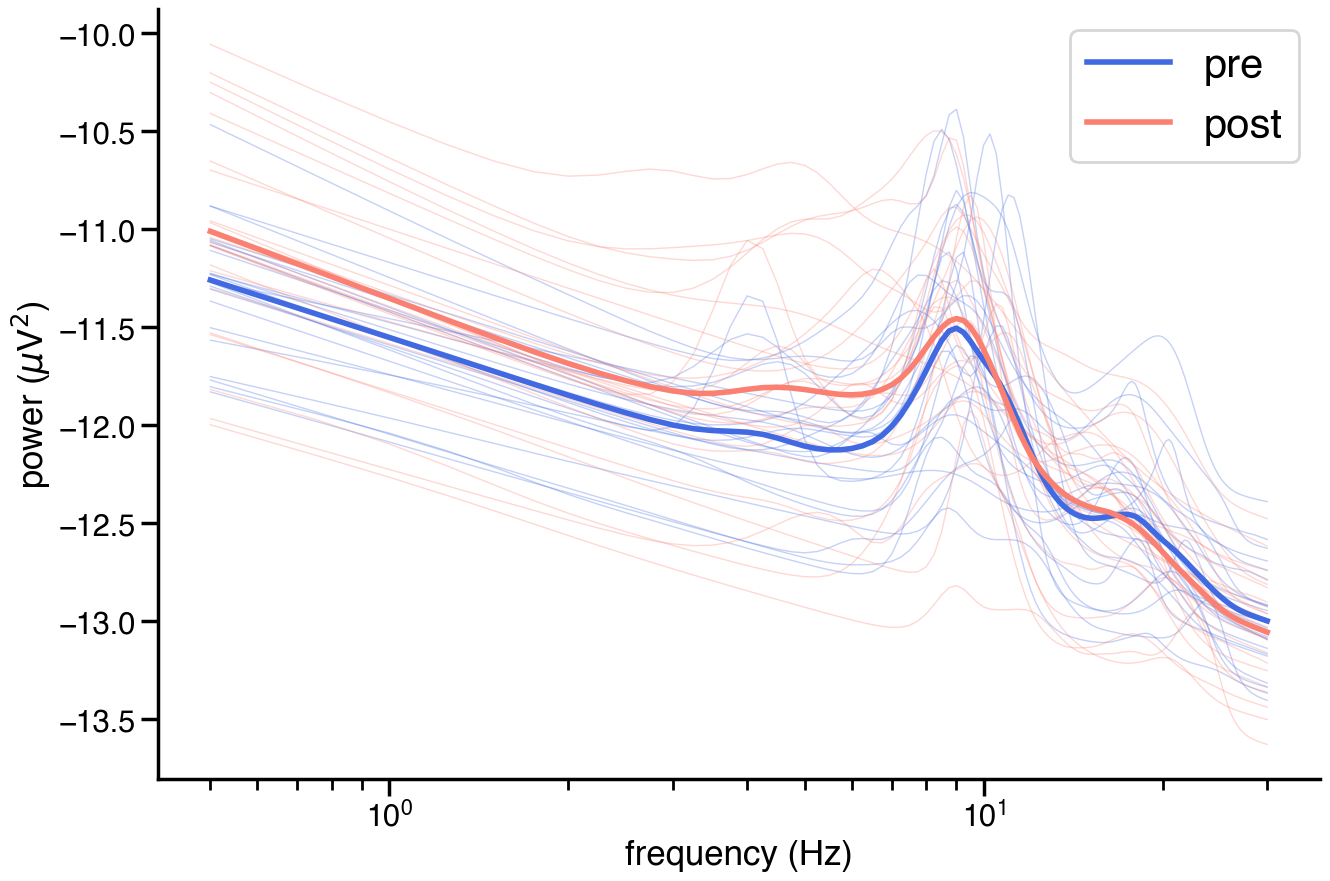

<Figure size 640x480 with 0 Axes>

In [19]:
sns.set_context('poster')
plt.figure(figsize=[15,10])

# plot patient pre
for patient in range(0, fits_pre_mean.shape[0]):
    plt.plot(freq_axis[2:121], fits_pre_mean[patient], color='royalblue', alpha = 0.3, linewidth = 1)

# plot patient post
for patient in range(0, fits_post_mean.shape[0]):
    plt.plot(freq_axis[2:121], fits_post_mean[patient], color='salmon', alpha = 0.3, linewidth = 1)

# plot average pre
plt.plot(freq_axis[2:121], fits_pre_grand_mean, color='royalblue', linewidth = 4, label='pre')

# plot average post
plt.plot(freq_axis[2:121], fits_post_grand_mean, color='salmon', linewidth = 4, label='post')


plt.xscale('log')
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.ylabel("power ($\mu$V$^2$)", fontsize = 25)
plt.xlabel("frequency (Hz)", fontsize = 25)
plt.legend(prop = {'size': 30})


sns.despine()

plt.show()
plt.savefig(fig_path+'spectra_fits.pdf', format='pdf')

## Plot SpecParam Fits

In [20]:
psd_pre_mean = np.nanmean(psd_pre_included, axis=1)
psd_post_mean = np.nanmean(psd_post_included, axis=1)

psd_pre_grand_mean = np.nanmean(psd_pre_included, axis=(0,1))
psd_post_grand_mean = np.nanmean(psd_post_included, axis=(0,1))

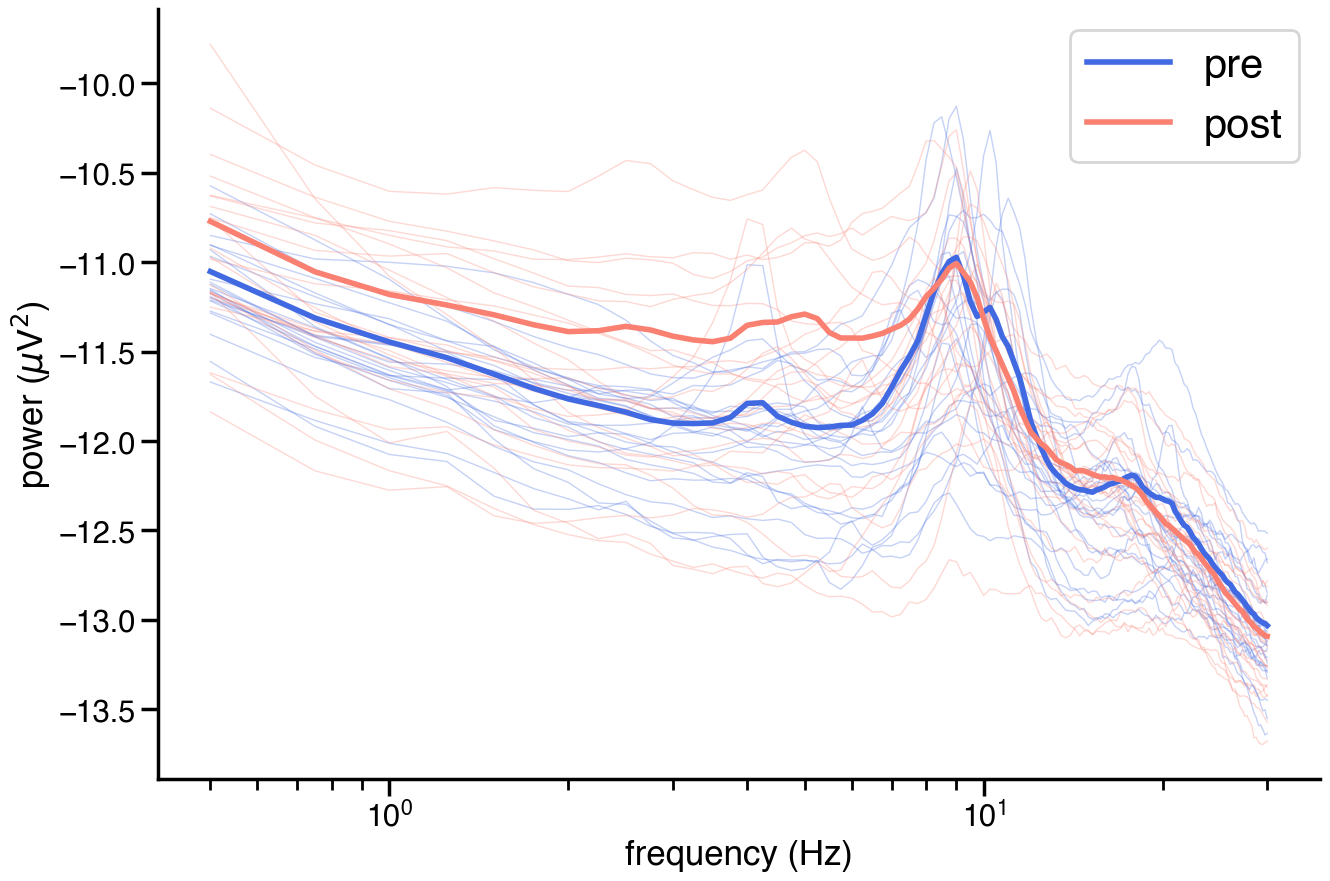

In [21]:
# plot patient pre

sns.set_context('poster')
plt.figure(figsize=[15,10])

for patient in range(0, psd_pre_mean.shape[0]):
    plt.plot(freq_axis[2:121], np.log10(psd_pre_mean[patient,2:121]), color='royalblue', alpha = 0.3, linewidth = 1)

# plot patient post
for patient in range(0, psd_post_mean.shape[0]):
    plt.plot(freq_axis[2:121], np.log10(psd_post_mean[patient,2:121]), color='salmon', alpha = 0.3, linewidth = 1)

# plot average pre
plt.plot(freq_axis[2:121], np.log10(psd_pre_grand_mean[2:121]), color='royalblue', linewidth = 4, label='pre')

# plot average post
plt.plot(freq_axis[2:121], np.log10(psd_post_grand_mean[2:121]), color='salmon', linewidth = 4, label='post')


plt.xscale('log')
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.ylabel("power ($\mu$V$^2$)", fontsize = 25)
plt.xlabel("frequency (Hz)", fontsize = 25)
plt.legend(prop = {'size': 30})


sns.despine()

plt.show()

# Statistics

### Exponent: Pre/Post

**Normality**

In [22]:
means_pre = exp_df_mean[exp_df_mean['pre_post']=='pre']['exponent'].values
means_post = exp_df_mean[exp_df_mean['pre_post']=='post']['exponent'].values

# normality test
print(normality(means_pre, method='shapiro'))
print(normality(means_post, method='shapiro'))

          W     pval  normal
0  0.986404  0.98224    True
          W      pval  normal
0  0.965802  0.589681    True


In [23]:
print('pre: ' + str(round(means_pre.mean(),2)) + ' std: ' + str(round(means_pre.std(),2)))
print('post: ' + str(round(means_post.mean(),2)) + ' std: ' + str(round(means_post.std(),2)))

pre: 0.97 std: 0.19
post: 1.15 std: 0.22


**Distribution of means pre vs. post**

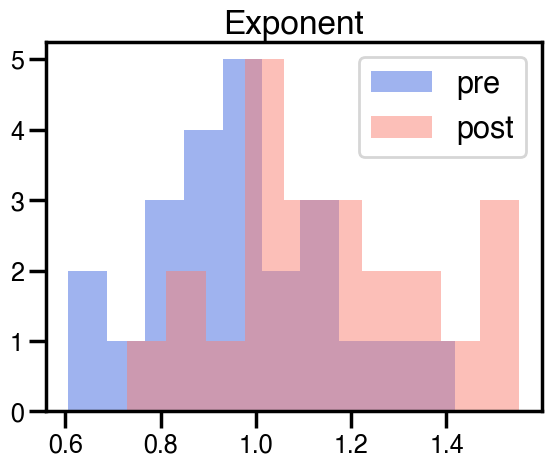

In [24]:
plt.hist(means_pre, color = 'royalblue', alpha = 0.5, label = 'pre')
plt.hist(means_post, color = 'salmon', alpha = 0.5, label = 'post')
plt.legend()
plt.title('Exponent')
plt.show()

**Wilcoxon Test**

In [25]:
print(wilcoxon(means_pre, means_post))

          W-val alternative     p-val       RBC      CLES
Wilcoxon   51.0   two-sided  0.006711 -0.630435  0.283554


**Permutation Test & T-Test**

The probability from the sampling statistics is =  0.1427 

               T  dof alternative     p-val           CI95%   cohen-d    BF10  \
T-test -3.360316   22   two-sided  0.002826  [-0.28, -0.07]  0.848965  14.372   

           power  
T-test  0.973081  


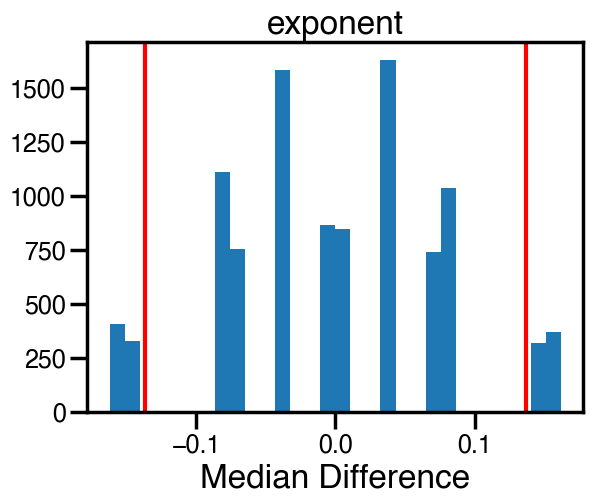

In [26]:
perm_test(exp_df_mean, feature='exponent')

### Offset: Pre/Post

In [27]:
means_pre = exp_df_mean[exp_df_mean['pre_post']=='pre']['offset'].values
means_post = exp_df_mean[exp_df_mean['pre_post']=='post']['offset'].values

# normality test
print(normality(means_pre, method='shapiro'))
print(normality(means_post, method='shapiro'))

          W      pval  normal
0  0.978695  0.882778    True
          W      pval  normal
0  0.957498  0.414757    True


**Distribution of means pre vs. post**

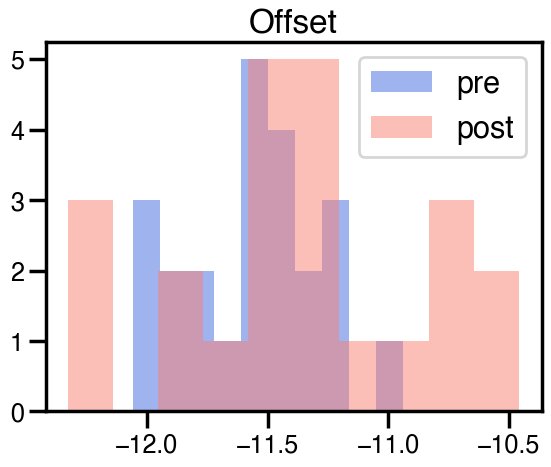

In [28]:
plt.hist(means_pre, color = 'royalblue', alpha = 0.5, label = 'pre')
plt.hist(means_post, color = 'salmon', alpha = 0.5, label = 'post')
plt.legend()
plt.title('Offset')
plt.show()

In [29]:
print(wilcoxon(means_pre, means_post))

          W-val alternative     p-val       RBC      CLES
Wilcoxon   77.0   two-sided  0.065036 -0.442029  0.376181


**Permutation Test & T-Test**

The probability from the sampling statistics is =  0.242 

               T  dof alternative    p-val         CI95%   cohen-d   BF10  \
T-test -2.037077   22   two-sided  0.05385  [-0.37, 0.0]  0.441499  1.246   

           power  
T-test  0.525773  


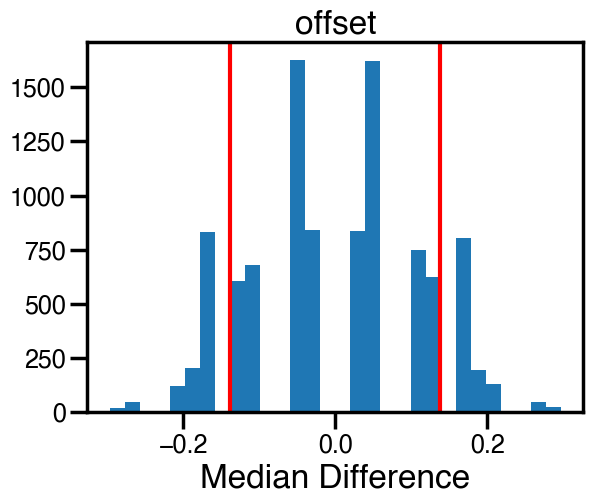

In [30]:
perm_test(exp_df_mean, feature='offset')

### Delta Oscillatory Power: Pre/Post

**Normality**

In [31]:
means_pre = exp_df_mean[exp_df_mean['pre_post']=='pre']['delta_amp'].values # .dropna(how="any")
means_post = exp_df_mean[exp_df_mean['pre_post']=='post']['delta_amp'].values

# normality test
print(normality(means_pre, method='shapiro'))
print(normality(means_post, method='shapiro'))

          W      pval  normal
0  0.922282  0.448657    True
          W      pval  normal
0  0.916867  0.366934    True


In [32]:
print('pre: ' + str(round(np.nanmean(means_pre),2)) + ' std: ' + str(round(np.nanstd(means_pre),2)))
print('post: ' + str(round(np.nanmean(means_post),2)) + ' std: ' + str(round(np.nanstd(means_post),2)))

pre: 0.21 std: 0.16
post: 0.45 std: 0.28


**Distribution of means pre vs. post**

This one is tricky to do stats for because the pre has so few channels that even detect a delta oscillation. When we try to keep the 0's instead of NaNs, the Wilcoxon test fails due to 'ties'. Therefore, we are keeping the NaNs, and will just report the permutation test for statistics.

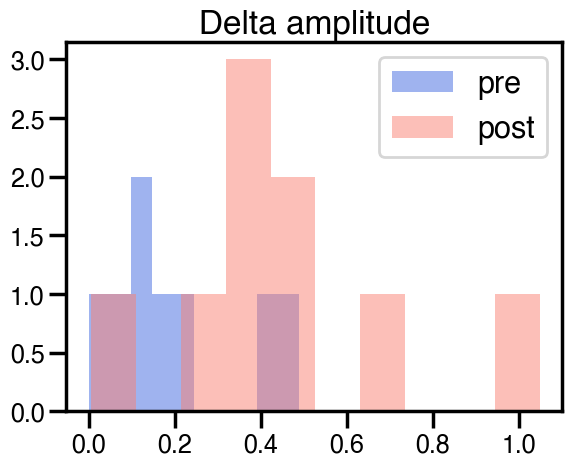

In [33]:
plt.hist(means_pre, color = 'royalblue', alpha = 0.5, label = 'pre')
plt.hist(means_post, color = 'salmon', alpha = 0.5, label = 'post')
plt.legend()
plt.title('Delta amplitude')
plt.show()

In [34]:
print(wilcoxon(means_pre, means_post))

          W-val alternative  p-val  RBC    CLES
Wilcoxon    2.0   two-sided  0.375 -0.6  0.3125


**Permutation Test & T-Test**

The probability from the sampling statistics is =  0.3758 

               T  dof alternative     p-val         CI95%   cohen-d   BF10  \
T-test -1.443651    3   two-sided  0.244554  [-0.6, 0.23]  0.916483  0.819   

           power  
T-test  0.252354  


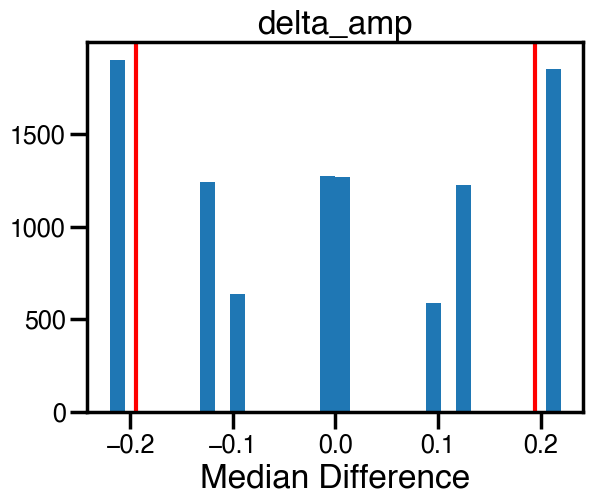

In [35]:
perm_test(exp_df_mean, feature='delta_amp')

### Delta Band Power: Pre/Post

**Normality**

In [36]:
means_pre = exp_df_mean[exp_df_mean['pre_post']=='pre']['delta_bp'].values
means_post = exp_df_mean[exp_df_mean['pre_post']=='post']['delta_bp'].values

# normality test
print(normality(means_pre, method='shapiro'))
print(normality(means_post, method='shapiro'))

          W      pval  normal
0  0.983127  0.951875    True
          W      pval  normal
0  0.971065  0.714491    True


In [37]:
print('pre: ' + str(round(means_pre.mean(),2)) + ' std: ' + str(round(means_pre.std(),2)))
print('post: ' + str(round(means_post.mean(),2)) + ' std: ' + str(round(means_post.std(),2)))

pre: -11.86 std: 0.25
post: -11.68 std: 0.5


**Distribution of means pre vs. post**

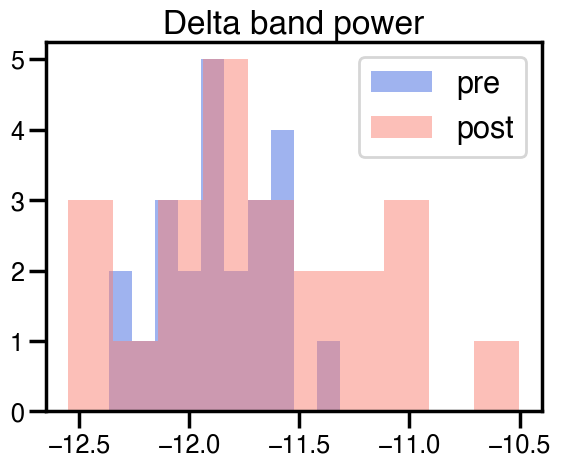

In [38]:
plt.hist(means_pre, color = 'royalblue', alpha = 0.5, label = 'pre')
plt.hist(means_post, color = 'salmon', alpha = 0.5, label = 'post')
plt.legend()
plt.title('Delta band power')
plt.show()

**Wilcoxon Test**

In [39]:
print(wilcoxon(means_pre, means_post))

          W-val alternative     p-val      RBC      CLES
Wilcoxon   80.0   two-sided  0.080203 -0.42029  0.396975


**Permutation Test & T-Test**

The probability from the sampling statistics is =  0.35850000000000004 

               T  dof alternative     p-val         CI95%   cohen-d   BF10  \
T-test -2.050567   22   two-sided  0.052409  [-0.37, 0.0]  0.455401  1.273   

           power  
T-test  0.551039  


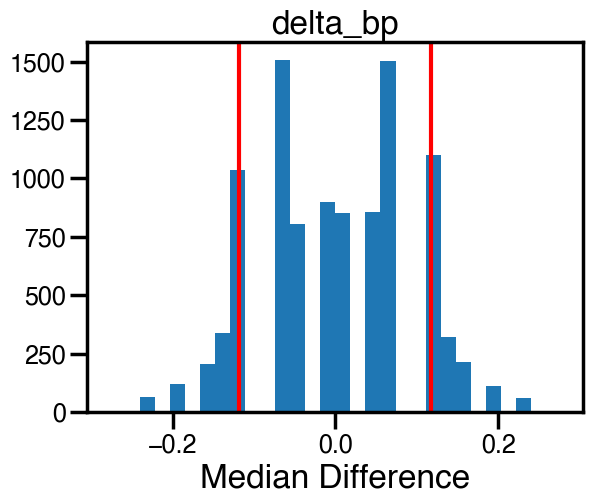

In [40]:
perm_test(exp_df_mean, feature='delta_bp')

### Delta Center Frequency: Pre/Post

**Normality**

In [41]:
means_pre = exp_df_mean[exp_df_mean['pre_post']=='pre']['delta_cf'].values
means_post = exp_df_mean[exp_df_mean['pre_post']=='post']['delta_cf'].values

# normality test
print(normality(means_pre, method='shapiro'))
print(normality(means_post, method='shapiro'))

          W      pval  normal
0  0.938087  0.592364    True
          W      pval  normal
0  0.892788  0.213088    True


**Distribution of means pre vs. post**

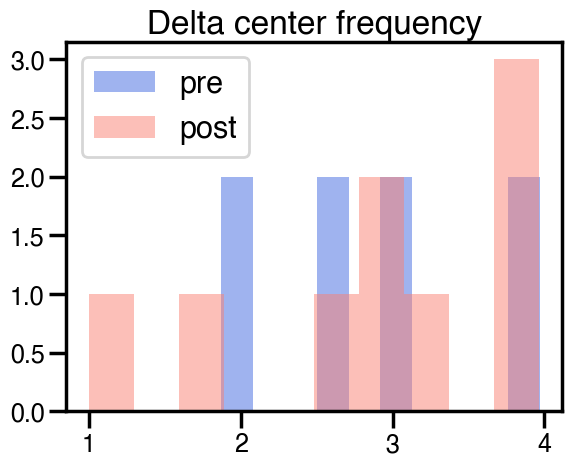

In [42]:
plt.hist(means_pre, color = 'royalblue', alpha = 0.5, label = 'pre')
plt.hist(means_post, color = 'salmon', alpha = 0.5, label = 'post')
plt.legend()
plt.title('Delta center frequency')
plt.show()

**Wilcoxon Test**

In [43]:
print(wilcoxon(means_pre, means_post))

          W-val alternative  p-val  RBC  CLES
Wilcoxon    0.0   two-sided  0.125  1.0  0.75


**Permutation Test & T-Test**

The probability from the sampling statistics is =  0.7528999999999999 

               T  dof alternative    p-val          CI95%   cohen-d   BF10  \
T-test  1.917619    3   two-sided  0.15099  [-0.45, 1.82]  0.589172  1.125   

           power  
T-test  0.135018  


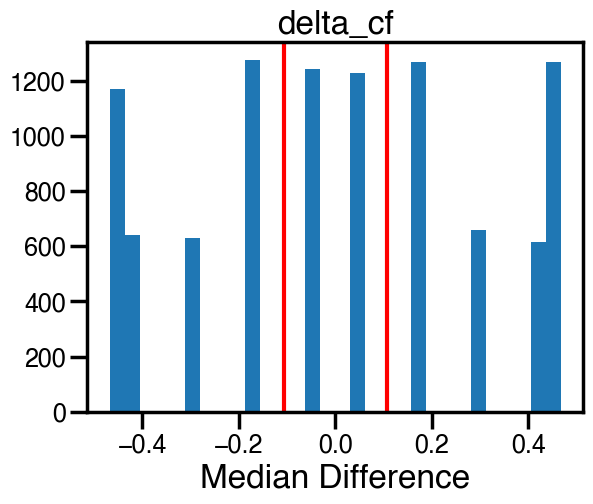

In [44]:
perm_test(exp_df_mean, feature='delta_cf')

### Theta Oscillatory Power: Pre/Post

**Normality**

In [45]:
means_pre = exp_df_mean[exp_df_mean['pre_post']=='pre']['theta_amp'].values
means_post = exp_df_mean[exp_df_mean['pre_post']=='post']['theta_amp'].values

# normality test
print(normality(means_pre, method='shapiro'))
print(normality(means_post, method='shapiro'))

          W     pval  normal
0  0.854285  0.01998   False
          W      pval  normal
0  0.931752  0.208447    True


In [46]:
print('pre: ' + str(round(np.nanmean(means_pre),2)) + ' std: ' + str(round(np.nanstd(means_pre),2)))
print('post: ' + str(round(np.nanmean(means_post),2)) + ' std: ' + str(round(np.nanstd(means_post),2)))

pre: 0.4 std: 0.19
post: 0.64 std: 0.28


**Distribution of means pre vs. post**

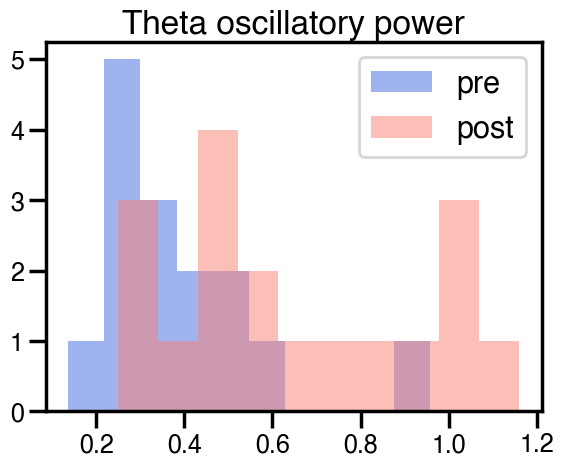

In [47]:
plt.hist(means_pre, color = 'royalblue', alpha = 0.5, label = 'pre')
plt.hist(means_post, color = 'salmon', alpha = 0.5, label = 'post')
plt.legend()
plt.title('Theta oscillatory power')
plt.show()

**Wilcoxon Test**

In [48]:
print(wilcoxon(means_pre, means_post))

          W-val alternative     p-val      RBC      CLES
Wilcoxon    4.0   two-sided  0.000854 -0.92381  0.183673


**Permutation Test & T-Test**

The probability from the sampling statistics is =  0.056400000000000006 

               T  dof alternative     p-val           CI95%   cohen-d    BF10  \
T-test -4.701156   13   two-sided  0.000414  [-0.44, -0.16]  1.223105  83.505   

           power  
T-test  0.988022  


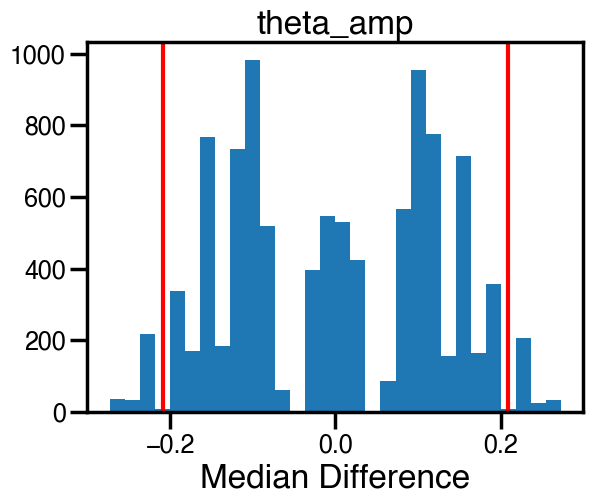

In [49]:
perm_test(exp_df_mean, feature='theta_amp')

### Theta Band Power: Pre/Post

**Normality**

In [50]:
means_pre = exp_df_mean[exp_df_mean['pre_post']=='pre']['theta_bp'].values
means_post = exp_df_mean[exp_df_mean['pre_post']=='post']['theta_bp'].values

# normality test
print(normality(means_pre, method='shapiro'))
print(normality(means_post, method='shapiro'))

         W      pval  normal
0  0.96456  0.561256    True
          W      pval  normal
0  0.978071  0.870828    True


In [51]:
print('pre: ' + str(round(means_pre.mean(),2)) + ' std: ' + str(round(means_pre.std(),2)))
print('post: ' + str(round(means_post.mean(),2)) + ' std: ' + str(round(means_post.std(),2)))

pre: -12.07 std: 0.37
post: -11.8 std: 0.63


**Distribution of means pre vs. post**

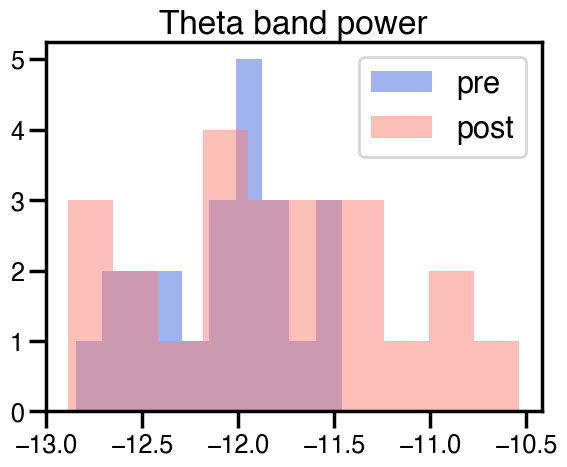

In [52]:
plt.hist(means_pre, color = 'royalblue', alpha = 0.5, label = 'pre')
plt.hist(means_post, color = 'salmon', alpha = 0.5, label = 'post')
plt.legend()
plt.title('Theta band power')
plt.show()

**Wilcoxon Test**

In [53]:
print(wilcoxon(means_pre, means_post))

          W-val alternative     p-val       RBC      CLES
Wilcoxon   57.0   two-sided  0.012295 -0.586957  0.359168


**Permutation Test & T-Test**

The probability from the sampling statistics is =  0.0814 

               T  dof alternative     p-val           CI95%  cohen-d   BF10  \
T-test -2.917099   22   two-sided  0.007985  [-0.47, -0.08]  0.52056  5.929   

           power  
T-test  0.665143  


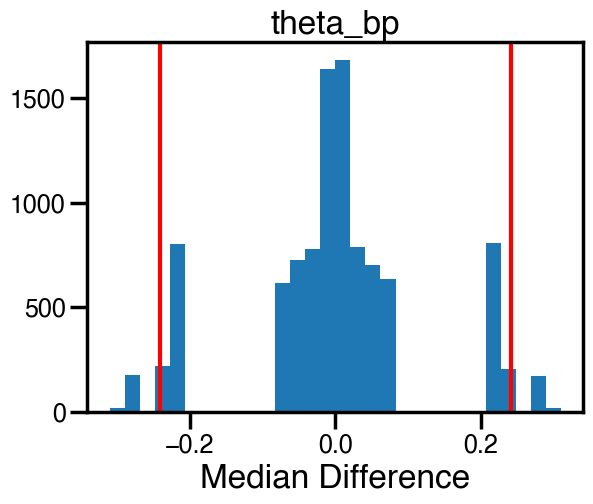

In [54]:
perm_test(exp_df_mean, feature='theta_bp')

### Theta Center Frequency: Pre/Post

**Normality**

In [55]:
means_pre = exp_df_mean[exp_df_mean['pre_post']=='pre']['theta_cf'].values
means_post = exp_df_mean[exp_df_mean['pre_post']=='post']['theta_cf'].values

# normality test
print(normality(means_pre, method='shapiro'))
print(normality(means_post, method='shapiro'))

          W      pval  normal
0  0.955292  0.611252    True
          W      pval  normal
0  0.940662  0.297435    True


**Distribution of means pre vs. post**

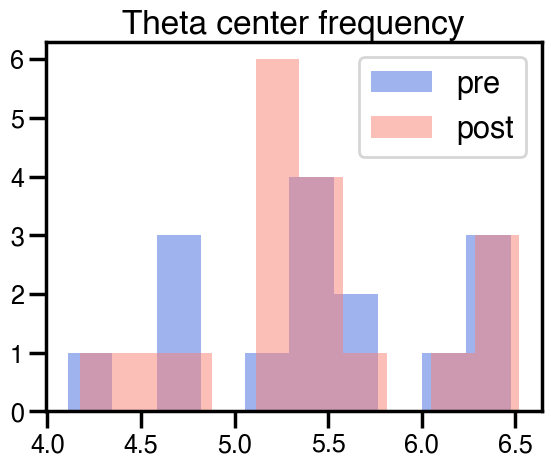

In [56]:
plt.hist(means_pre, color = 'royalblue', alpha = 0.5, label = 'pre')
plt.hist(means_post, color = 'salmon', alpha = 0.5, label = 'post')
plt.legend()
plt.title('Theta center frequency')
plt.show()

**Wilcoxon Test**

In [57]:
print(wilcoxon(means_pre, means_post))

          W-val alternative     p-val       RBC      CLES
Wilcoxon   48.0   two-sided  0.807739 -0.085714  0.469388


**Permutation Test & T-Test**

The probability from the sampling statistics is =  0.8844000000000001 

               T  dof alternative     p-val         CI95%   cohen-d   BF10  \
T-test -0.437072   13   two-sided  0.669232  [-0.46, 0.3]  0.118222  0.294   

           power  
T-test  0.069529  


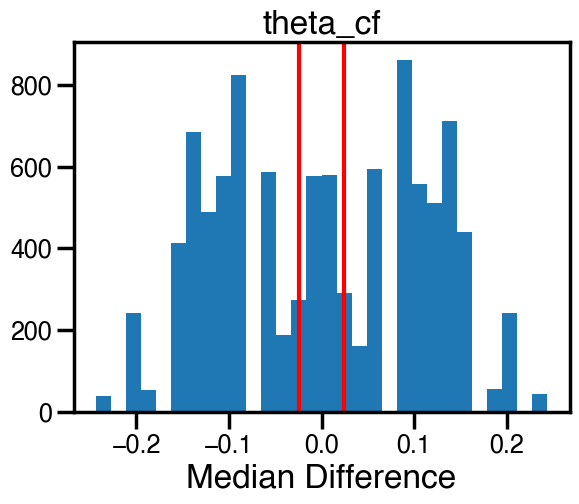

In [58]:
perm_test(exp_df_mean, feature='theta_cf')

### Alpha Oscillatory Power: Pre/Post

**Normality**

In [59]:
means_pre = exp_df_mean[exp_df_mean['pre_post']=='pre']['alpha_amp'].values
means_post = exp_df_mean[exp_df_mean['pre_post']=='post']['alpha_amp'].values

# normality test
print(normality(means_pre, method='shapiro'))
print(normality(means_post, method='shapiro'))

         W      pval  normal
0  0.94774  0.262511    True
          W      pval  normal
0  0.974827  0.802257    True


In [60]:
print('pre: ' + str(round(means_pre.mean(),2)) + ' std: ' + str(round(means_pre.std(),2)))
print('post: ' + str(round(means_post.mean(),2)) + ' std: ' + str(round(means_post.std(),2)))

pre: 1.13 std: 0.51
post: 1.06 std: 0.41


**Distribution of means pre vs. post**

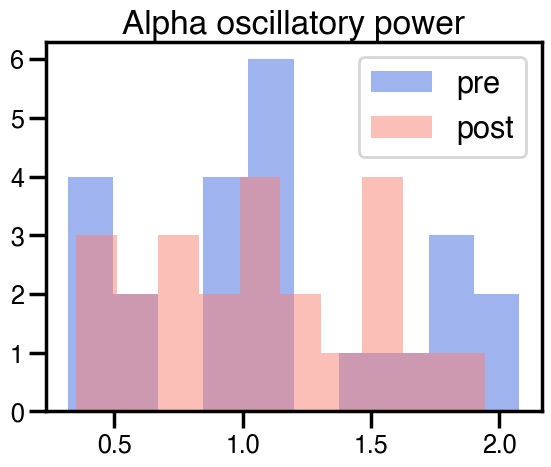

In [61]:
plt.hist(means_pre, color = 'royalblue', alpha = 0.5, label = 'pre')
plt.hist(means_post, color = 'salmon', alpha = 0.5, label = 'post')
plt.legend()
plt.title('Alpha oscillatory power')
plt.show()

**Wilcoxon Test**

In [62]:
print(wilcoxon(means_pre, means_post))

          W-val alternative     p-val       RBC      CLES
Wilcoxon   98.0   two-sided  0.234471  0.289855  0.538752


**Permutation Test & T-Test**

The probability from the sampling statistics is =  0.3546 

               T  dof alternative     p-val          CI95%   cohen-d   BF10  \
T-test  0.987601   22   two-sided  0.334086  [-0.08, 0.22]  0.147386  0.338   

          power  
T-test  0.10384  


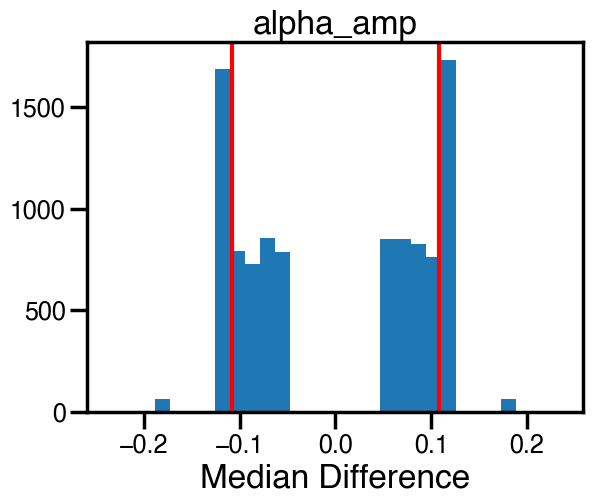

In [63]:
perm_test(exp_df_mean, feature='alpha_amp')

### Alpha Band Power: Pre/Post

**Normality**

In [64]:
means_pre = exp_df_mean[exp_df_mean['pre_post']=='pre']['alpha_bp'].values
means_post = exp_df_mean[exp_df_mean['pre_post']=='post']['alpha_bp'].values

# normality test
print(normality(means_pre, method='shapiro'))
print(normality(means_post, method='shapiro'))

          W      pval  normal
0  0.946949  0.252655    True
          W      pval  normal
0  0.975405  0.815129    True


In [65]:
print('pre: ' + str(round(means_pre.mean(),2)) + ' std: ' + str(round(means_pre.std(),2)))
print('post: ' + str(round(means_post.mean(),2)) + ' std: ' + str(round(means_post.std(),2)))

pre: -11.68 std: 0.46
post: -11.66 std: 0.51


**Distribution of means pre vs. post**

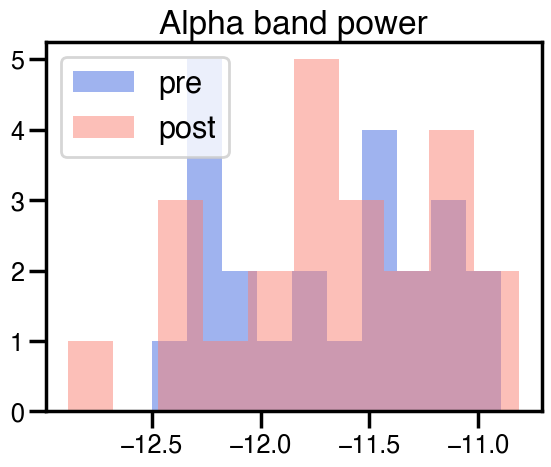

In [66]:
plt.hist(means_pre, color = 'royalblue', alpha = 0.5, label = 'pre')
plt.hist(means_post, color = 'salmon', alpha = 0.5, label = 'post')
plt.legend()
plt.title('Alpha band power')
plt.show()

**Wilcoxon Test**

In [67]:
print(wilcoxon(means_pre, means_post))

          W-val alternative     p-val       RBC      CLES
Wilcoxon  126.0   two-sided  0.731389 -0.086957  0.483932


**Permutation Test + T-Test**

The probability from the sampling statistics is =  0.2395 

               T  dof alternative     p-val          CI95%   cohen-d   BF10  \
T-test -0.367018   22   two-sided  0.717112  [-0.12, 0.08]  0.035956  0.233   

           power  
T-test  0.053126  


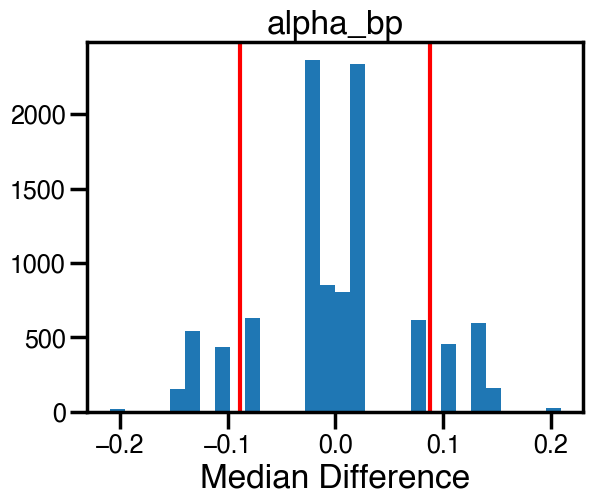

In [68]:
perm_test(exp_df_mean, feature='alpha_bp')

### Alpha Center Frequency: Pre/Post

**Normality**

In [69]:
means_pre = exp_df_mean[exp_df_mean['pre_post']=='pre']['alpha_cf'].values
means_post = exp_df_mean[exp_df_mean['pre_post']=='post']['alpha_cf'].values

# normality test
print(normality(means_pre, method='shapiro'))
print(normality(means_post, method='shapiro'))

          W      pval  normal
0  0.954711  0.365235    True
          W      pval  normal
0  0.876839  0.008684   False


**Distribution of means pre vs. post**

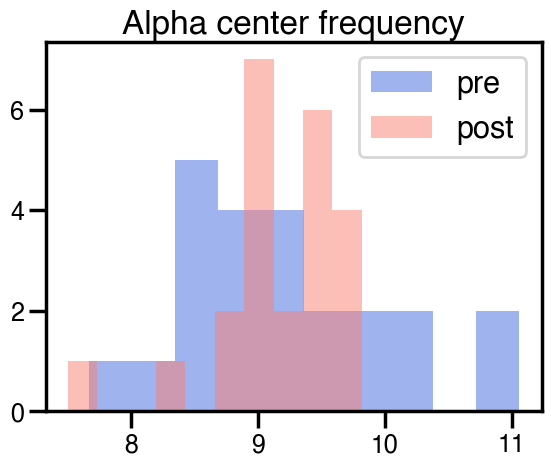

In [70]:
plt.hist(means_pre, color = 'royalblue', alpha = 0.5, label = 'pre')
plt.hist(means_post, color = 'salmon', alpha = 0.5, label = 'post')
plt.legend()
plt.title('Alpha center frequency')
plt.show()

**Wilcoxon Test**

In [71]:
print(wilcoxon(means_pre, means_post))

          W-val alternative     p-val       RBC      CLES
Wilcoxon  120.0   two-sided  0.601046  0.130435  0.478261


**Permutation Test & T-Test**

The probability from the sampling statistics is =  0.3564 

               T  dof alternative   p-val          CI95%   cohen-d   BF10  \
T-test  0.603727   22   two-sided  0.5522  [-0.18, 0.33]  0.106884  0.258   

           power  
T-test  0.077996  


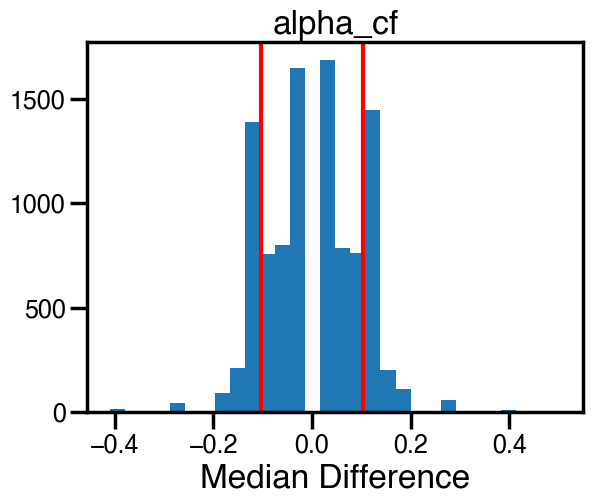

In [72]:
perm_test(exp_df_mean, feature='alpha_cf')

## Presence/Absence/Percentage of Channels with Oscillations

We are determining what % of channels have a delta oscillation per participant, per pre/post

### Delta Percentage

In [73]:
# Create a new df to find # of channels per person per pre/post that do not have 'nan' 
# (aka that have a delta oscillation)

features = ['patient','pre_post','channel','delta_cf']
exp_df_delta_osc = exp_df_included[features]
exp_df_delta_osc['delta_present'] = exp_df_delta_osc['delta_cf'].notna()

/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_6573/259686611.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp_df_delta_osc['delta_present'] = exp_df_delta_osc['delta_cf'].notna()


In [74]:
# With this new df, we want to group by the patient/pre_post to show how many channels have a delta oscillation
# Also need to calculate the total # of channels b/c need to get a percentage 
# (not all pts have same # of channels due to exclusion criteria)

ch_delta = exp_df_delta_osc.groupby(['patient', 'pre_post'])['delta_present'].sum().values
ch_total = exp_df_delta_osc.groupby(['patient', 'pre_post'])['channel'].count().values

ch_delta_perc = ch_delta/ch_total

In [75]:
# Add the delta oscillation percentages to the other df to determine which value corresponds to pre/post

delta_osc_perc = pd.DataFrame(exp_df_delta_osc.groupby(['patient', 'pre_post'], as_index=False)['delta_present'].sum())
delta_osc_perc['ch_delta_perc'] = ch_delta_perc

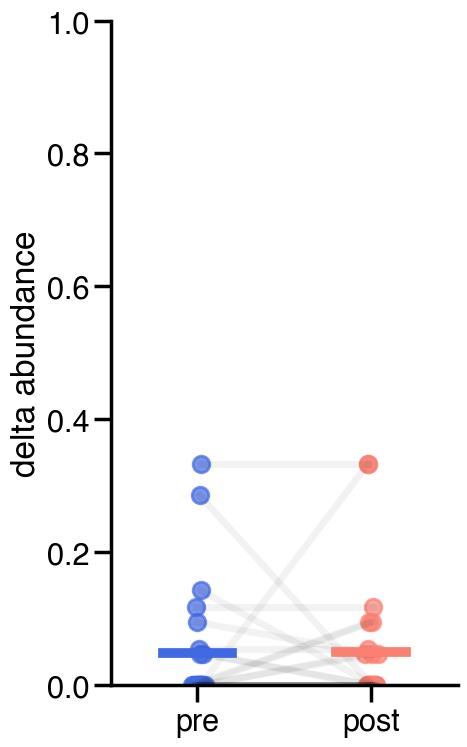

In [76]:
plot_feature_prepost(delta_osc_perc, feature='ch_delta_perc')
plt.ylim(0, 1) # same y axis as ECT
plt.ylabel('delta abundance')
sns.despine()
plt.show()

**Normality**

In [77]:
perc_delta_pre = delta_osc_perc[delta_osc_perc['pre_post']=='pre']['ch_delta_perc'].values
perc_delta_post = delta_osc_perc[delta_osc_perc['pre_post']=='post']['ch_delta_perc'].values

# normality test
print(normality(perc_delta_pre, method='shapiro'))
print(normality(perc_delta_post, method='shapiro'))

          W      pval  normal
0  0.606395  0.000001   False
          W          pval  normal
0  0.583685  6.005187e-07   False


In [78]:
print('pre: ' + str(round(perc_delta_pre.mean(),2)) + ' std: ' + str(round(perc_delta_pre.std(),2)))
print('post: ' + str(round(perc_delta_post.mean(),2)) + ' std: ' + str(round(perc_delta_post.std(),2)))

pre: 0.05 std: 0.09
post: 0.05 std: 0.09


**Wilcoxon Test**

In [79]:
print(wilcoxon(perc_delta_pre, perc_delta_post))

          W-val alternative     p-val       RBC      CLES
Wilcoxon   26.0   two-sided  0.917686 -0.054545  0.485822


/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


**Permutation Test & T-Test**

The probability from the sampling statistics is =  2.0 

               T  dof alternative     p-val          CI95%   cohen-d  BF10  \
T-test -0.094568   22   two-sided  0.925514  [-0.05, 0.04]  0.021911  0.22   

          power  
T-test  0.05116  


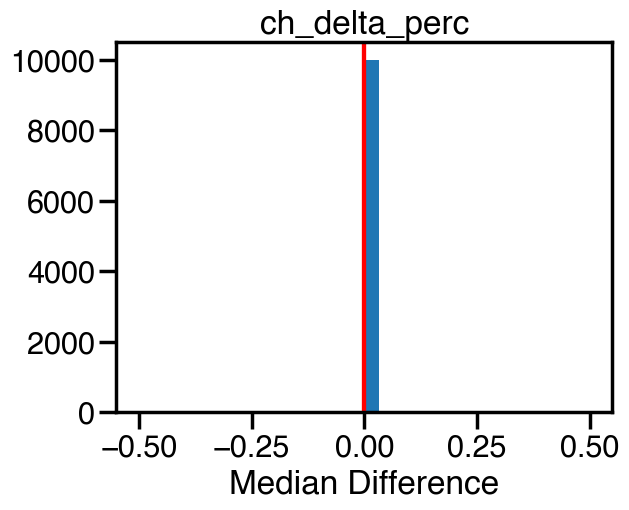

In [80]:
perm_test(delta_osc_perc, feature='ch_delta_perc')

### Theta Percentage

In [81]:
# Create a new df to find # of channels per person per pre/post that do not have 'nan' 
# (aka that have a theta oscillation)

features = ['patient','pre_post','channel','theta_cf']
exp_df_theta_osc = exp_df_included[features]
exp_df_theta_osc['theta_present'] = exp_df_theta_osc['theta_cf'].notna()

/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_6573/2939216184.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp_df_theta_osc['theta_present'] = exp_df_theta_osc['theta_cf'].notna()


In [82]:
# With this new df, we want to group by the patient/pre_post to show how many channels have a theta oscillation
# Also need to calculate the total # of channels b/c need to get a percentage 
# (not all pts have same # of channels due to exclusion criteria)

ch_theta = exp_df_theta_osc.groupby(['patient', 'pre_post'])['theta_present'].sum().values
ch_total = exp_df_theta_osc.groupby(['patient', 'pre_post'])['channel'].count().values

ch_theta_perc = ch_theta/ch_total

In [83]:
# Add the theta oscillation percentages to the other df to determine which value corresponds to pre/post

theta_osc_perc = pd.DataFrame(exp_df_theta_osc.groupby(['patient', 'pre_post'], as_index=False)['theta_present'].sum())
theta_osc_perc['ch_theta_perc'] = ch_theta_perc

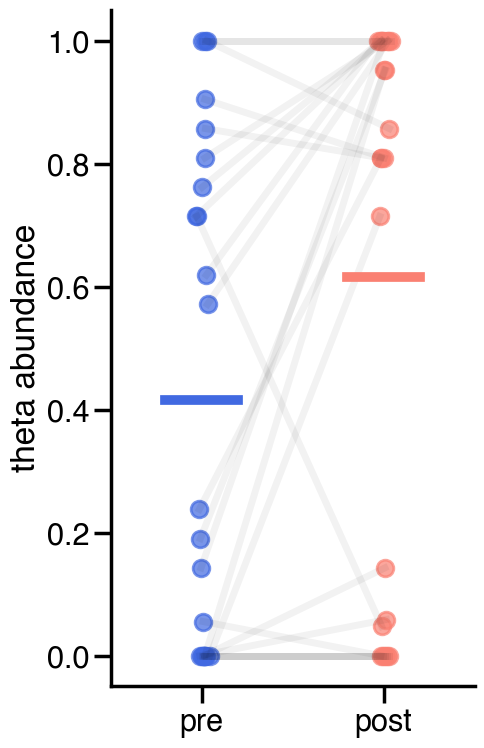

In [84]:
plot_feature_prepost(theta_osc_perc, feature='ch_theta_perc')
plt.ylabel('theta abundance')
sns.despine()
plt.show()

In [85]:
perc_theta_pre = theta_osc_perc[theta_osc_perc['pre_post']=='pre']['ch_theta_perc'].values
perc_theta_post = theta_osc_perc[theta_osc_perc['pre_post']=='post']['ch_theta_perc'].values

In [86]:
print('pre: ' + str(round(perc_theta_pre.mean(),2)) + ' std: ' + str(round(perc_theta_pre.std(),2)))
print('post: ' + str(round(perc_theta_post.mean(),2)) + ' std: ' + str(round(perc_theta_post.std(),2)))

pre: 0.42 std: 0.4
post: 0.62 std: 0.43


**Wilcoxon Test**

In [87]:
print(wilcoxon(perc_theta_pre, perc_theta_post))

          W-val alternative     p-val       RBC      CLES
Wilcoxon   26.0   two-sided  0.017938 -0.660131  0.348771


/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


**Permutation Test & T-Test**

The probability from the sampling statistics is =  0.0 

               T  dof alternative     p-val           CI95%   cohen-d   BF10  \
T-test -2.518656   22   two-sided  0.019553  [-0.36, -0.04]  0.466848  2.813   

           power  
T-test  0.571694  


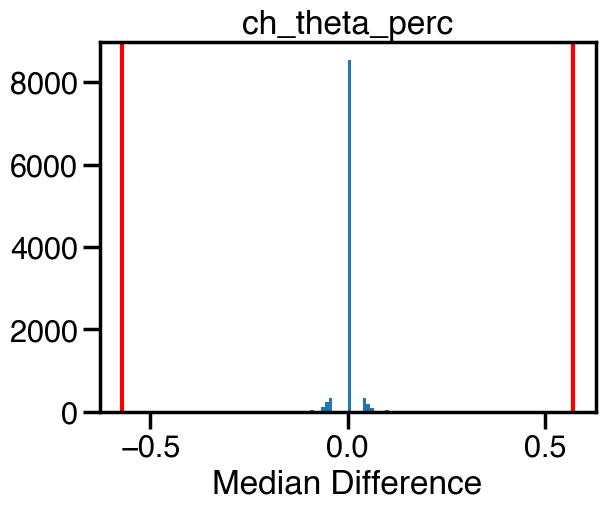

In [88]:
perm_test(theta_osc_perc, feature='ch_theta_perc')

### Alpha Percentage

In [89]:
# Create a new df to find # of channels per person per pre/post that do not have 'nan' 
# (aka that have an alpha oscillation)

features = ['patient','pre_post','channel','alpha_cf']
exp_df_alpha_osc = exp_df_included[features]
exp_df_alpha_osc['alpha_present'] = exp_df_alpha_osc['alpha_cf'].notna()

/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_6573/4032763983.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp_df_alpha_osc['alpha_present'] = exp_df_alpha_osc['alpha_cf'].notna()


In [90]:
# With this new df, we want to group by the patient/pre_post to show how many channels have an alpha oscillation
# Also need to calculate the total # of channels b/c need to get a percentage 
# (not all pts have same # of channels due to exclusion criteria)

ch_alpha = exp_df_alpha_osc.groupby(['patient', 'pre_post'])['alpha_present'].sum().values
ch_total = exp_df_alpha_osc.groupby(['patient', 'pre_post'])['channel'].count().values

ch_alpha_perc = ch_alpha/ch_total

In [91]:
# Add the alpha oscillation percentages to the other df to determine which value corresponds to pre/post

alpha_osc_perc = pd.DataFrame(exp_df_alpha_osc.groupby(['patient', 'pre_post'], as_index=False)['alpha_present'].sum())
alpha_osc_perc['ch_alpha_perc'] = ch_alpha_perc

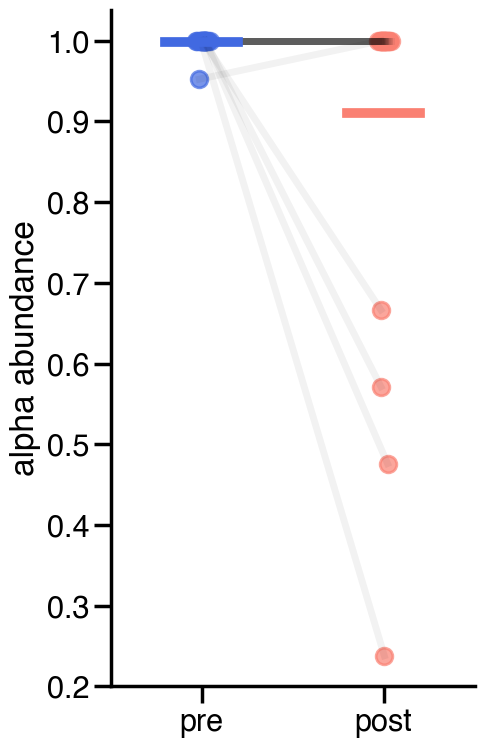

In [92]:
plot_feature_prepost(alpha_osc_perc, feature='ch_alpha_perc')
plt.ylabel('alpha abundance')
sns.despine()
plt.show()

In [93]:
perc_alpha_pre = alpha_osc_perc[alpha_osc_perc['pre_post']=='pre']['ch_alpha_perc'].values
perc_alpha_post = alpha_osc_perc[alpha_osc_perc['pre_post']=='post']['ch_alpha_perc'].values

In [94]:
print('pre: ' + str(round(perc_alpha_pre.mean(),2)) + ' std: ' + str(round(perc_alpha_pre.std(),2)))
print('post: ' + str(round(perc_alpha_post.mean(),2)) + ' std: ' + str(round(perc_alpha_post.std(),2)))

pre: 1.0 std: 0.01
post: 0.91 std: 0.21


**Wilcoxon Test**

In [95]:
print(wilcoxon(perc_alpha_pre, perc_alpha_post))

          W-val alternative     p-val       RBC      CLES
Wilcoxon    1.0   two-sided  0.105645  0.866667  0.568998


/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/scipy/stats/morestats.py:3155: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


**Permutation Test & T-Test**

The probability from the sampling statistics is =  2.0 

               T  dof alternative     p-val         CI95%   cohen-d   BF10  \
T-test  1.977902   22   two-sided  0.060599  [-0.0, 0.18]  0.585796  1.137   

           power  
T-test  0.765791  


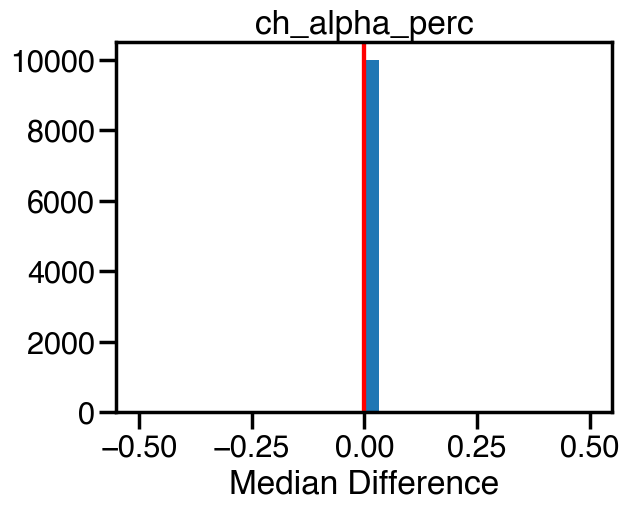

In [96]:
perm_test(alpha_osc_perc, feature='ch_alpha_perc')

## Merge Percentage Oscillation Dataframes

In [97]:
# merge percentage dfs
perc_df = pd.merge(theta_osc_perc, delta_osc_perc, how='outer', on=['patient', 'pre_post'])
perc_df = pd.merge(perc_df, alpha_osc_perc, how='outer', on=['patient', 'pre_post'])

In [98]:
# merge perc with main eeg feature df
exp_df_mean_wperc = pd.merge(exp_df_mean, perc_df, how='outer', on=['patient', 'pre_post'])

In [99]:
exp_df_mean_wperc.head()

,patient,pre_post,exponent,offset,delta_amp,delta_bp,theta_amp,theta_bp,theta_cf,delta_cf,alpha_amp,alpha_bp,alpha_bw,alpha_cf,theta_present,ch_theta_perc,delta_present,ch_delta_perc,alpha_present,ch_alpha_perc
0,9,post,1.166882,-11.383574,NaN,-11.706346,0.610189,-11.694951,5.125341,NaN,1.037723,-11.718404,2.246162,9.334918,21,1.000000,0,0.000000,21,1.000000
1,9,pre,1.418123,-10.937702,1.428371e-01,-11.315082,0.516103,-11.469126,5.367909,2.008761,0.967401,-11.435478,4.284732,9.149521,12,0.571429,1,0.047619,21,1.000000
2,10,post,0.894018,-12.240782,4.740232e-01,-12.549689,NaN,-12.886059,NaN,1.000000,0.349827,-12.885542,1.574571,9.420771,0,0.000000,1,0.055556,12,0.666667
3,10,pre,0.901056,-11.962090,8.154322e-07,-12.272586,0.268704,-12.589385,6.461920,2.676020,0.433698,-12.498315,2.796287,9.546040,1,0.055556,1,0.055556,18,1.000000
4,18,post,1.173880,-11.326314,NaN,-11.684360,0.249402,-12.091654,6.519227,NaN,1.060565,-11.660719,1.358755,8.756279,1,0.047619,0,0.000000,21,1.000000


## Multiple Regression Spectral Analysis

What EEG features may be predictive of other EEG features? Specifically, what might be driving the band power differences pre vs. post?

### Using Treatment Difference

**Take difference of pre - post**

In [100]:
# Take features of interest + average over all electrodes per patient
features = ['exponent', 'offset', 'delta_amp', 'delta_bp', 'theta_amp', 'theta_bp', 'theta_cf', 'delta_cf',
            'alpha_amp', 'alpha_bp', 'alpha_cf', 'ch_theta_perc', 'ch_delta_perc', 'ch_alpha_perc']


diff_df_mean_wperc = exp_df_mean_wperc.groupby(['patient'], as_index=False)[features].diff().dropna(0, how='all')
diff_df_mean_wperc['patient'] = exp_df_mean_wperc['patient']

diff_df_mean_wperc

/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_6573/1529135655.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  diff_df_mean_wperc = exp_df_mean_wperc.groupby(['patient'], as_index=False)[features].diff().dropna(0, how='all')


,exponent,offset,delta_amp,delta_bp,theta_amp,theta_bp,theta_cf,delta_cf,alpha_amp,alpha_bp,alpha_cf,ch_theta_perc,ch_delta_perc,ch_alpha_perc,patient
1,0.251241,0.445872,NaN,0.391264,-0.094086,0.225825,0.242568,NaN,-0.070322,0.282926,-0.185397,-0.428571,0.047619,0.000000,9
3,0.007038,0.278691,-0.474022,0.277103,NaN,0.296675,NaN,1.676020,0.083871,0.387227,0.125268,0.055556,0.000000,0.333333,10
5,0.082965,0.130354,NaN,0.070714,0.131730,0.314946,-1.321810,NaN,0.120242,0.132427,-0.121920,0.666667,0.000000,0.000000,18
7,-0.154217,-0.314414,NaN,-0.357518,NaN,-0.515141,NaN,NaN,0.317022,-0.108952,-0.060471,0.000000,0.000000,0.000000,22
9,0.042866,0.538198,NaN,0.590363,NaN,0.309868,NaN,NaN,-0.778418,-0.278628,-0.809445,-0.142857,0.000000,0.000000,25
11,-0.535556,-0.580304,NaN,-0.585073,-0.496169,-0.623341,0.244583,NaN,0.235333,0.024690,0.018767,0.000000,-0.333333,0.000000,33
13,-0.071347,-0.177975,-0.106604,-0.198099,-0.517354,-0.369288,-0.715946,0.127076,0.181818,0.010456,0.165665,-0.857143,0.047619,0.761905,35
15,-0.386498,-0.330098,NaN,-0.224554,NaN,-0.053009,NaN,NaN,-0.097648,-0.015390,-0.694014,0.000000,0.000000,0.000000,40
17,-0.083870,0.021992,NaN,0.049137,-0.117113,0.002270,-0.060516,NaN,0.056855,0.144221,0.036954,-0.238095,0.000000,0.000000,46
19,0.158450,0.260587,NaN,0.164750,NaN,0.331142,NaN,NaN,-0.312322,0.081481,-0.800935,0.000000,0.285714,0.000000,47


In [101]:
# multiple linear regression to see where changes in delta & theta come from
model = ols('delta_bp ~ exponent + ch_delta_perc', diff_df_mean_wperc).fit() # not using amp because not enough values
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               delta_bp   R-squared:                       0.744
Model:                            OLS   Adj. R-squared:                  0.719
Method:                 Least Squares   F-statistic:                     29.13
Date:                Wed, 03 May 2023   Prob (F-statistic):           1.19e-06
Time:                        14:32:13   Log-Likelihood:                 2.9498
No. Observations:                  23   AIC:                            0.1004
Df Residuals:                      20   BIC:                             3.507
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0872      0.060      1.442

In [102]:
model = ols('theta_bp ~ exponent + ch_theta_perc', diff_df_mean_wperc).fit() # not using amp because not enough values
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               theta_bp   R-squared:                       0.698
Model:                            OLS   Adj. R-squared:                  0.668
Method:                 Least Squares   F-statistic:                     23.15
Date:                Wed, 03 May 2023   Prob (F-statistic):           6.23e-06
Time:                        14:32:13   Log-Likelihood:               -0.14109
No. Observations:                  23   AIC:                             6.282
Df Residuals:                      20   BIC:                             9.689
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0169      0.070      0.241

In [103]:
model = ols('alpha_bp ~ exponent + alpha_amp + ch_alpha_perc', diff_df_mean_wperc).fit() # not using amp because not enough values
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               alpha_bp   R-squared:                       0.471
Model:                            OLS   Adj. R-squared:                  0.387
Method:                 Least Squares   F-statistic:                     5.635
Date:                Wed, 03 May 2023   Prob (F-statistic):            0.00617
Time:                        14:32:13   Log-Likelihood:                 8.5087
No. Observations:                  23   AIC:                            -9.017
Df Residuals:                      19   BIC:                            -4.475
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0637      0.049      1.292

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='theta_amp', ylabel='theta_bp'>

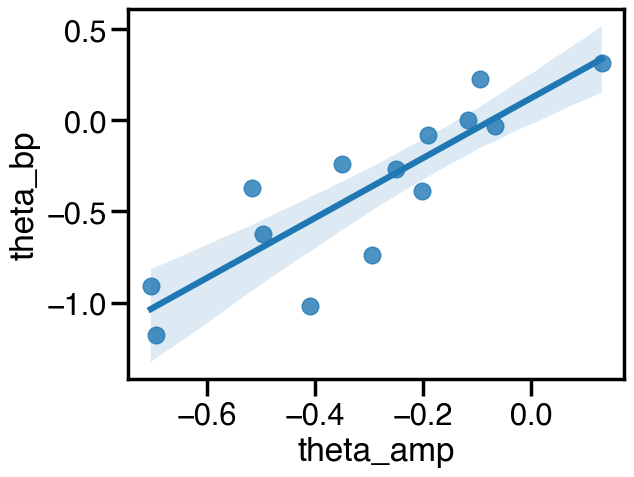

In [104]:
sns.regplot(diff_df_mean_wperc['theta_amp'], diff_df_mean_wperc['theta_bp'])

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='ch_theta_perc', ylabel='theta_bp'>

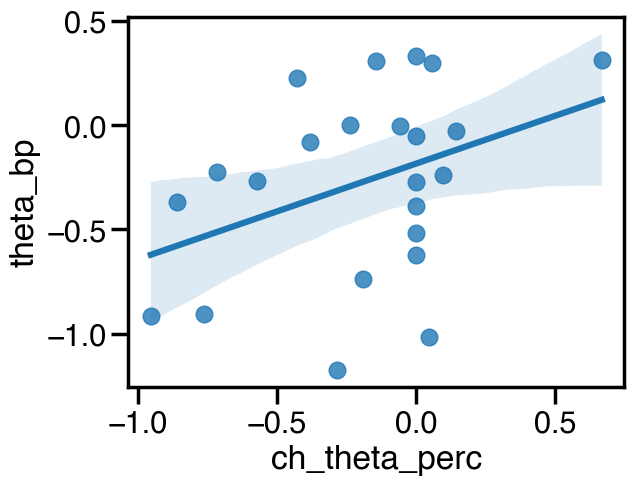

In [105]:
sns.regplot(diff_df_mean_wperc['ch_theta_perc'], diff_df_mean_wperc['theta_bp'])

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='offset', ylabel='theta_bp'>

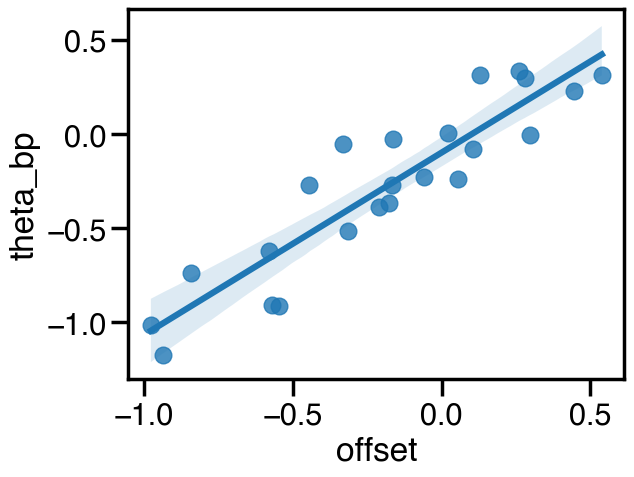

In [106]:
sns.regplot(diff_df_mean_wperc['offset'], diff_df_mean_wperc['theta_bp'])

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='exponent', ylabel='theta_bp'>

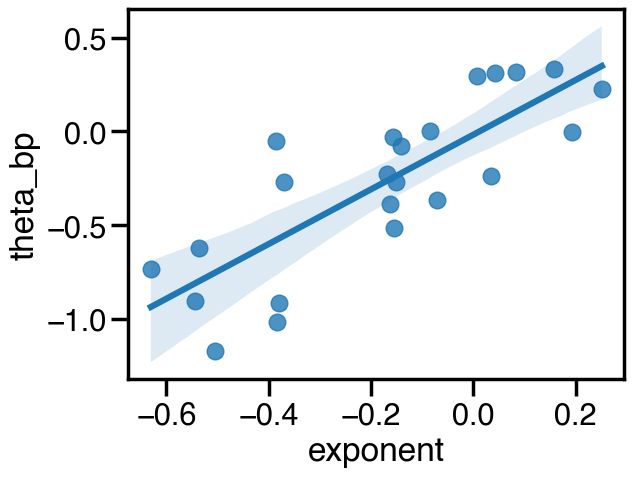

In [107]:
sns.regplot(diff_df_mean_wperc['exponent'], diff_df_mean_wperc['theta_bp'])

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='exponent', ylabel='delta_bp'>

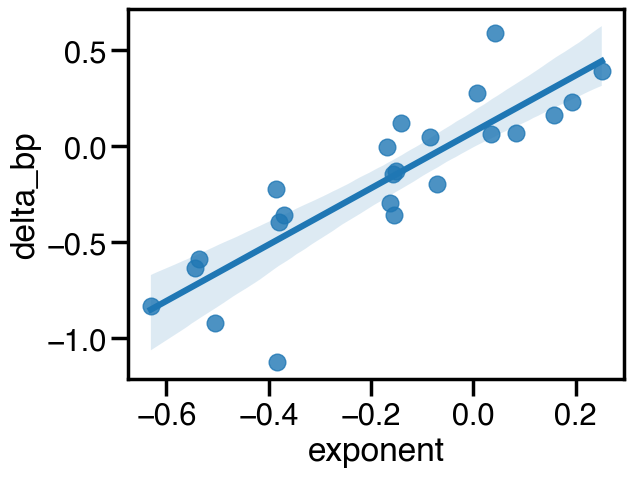

In [108]:
sns.regplot(diff_df_mean_wperc['exponent'], diff_df_mean_wperc['delta_bp'])

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='delta_amp', ylabel='delta_bp'>

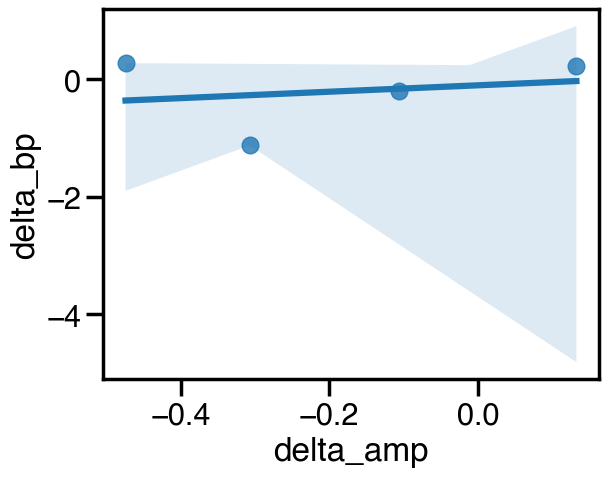

In [109]:
sns.regplot(diff_df_mean_wperc['delta_amp'], diff_df_mean_wperc['delta_bp'])

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='ch_delta_perc', ylabel='delta_bp'>

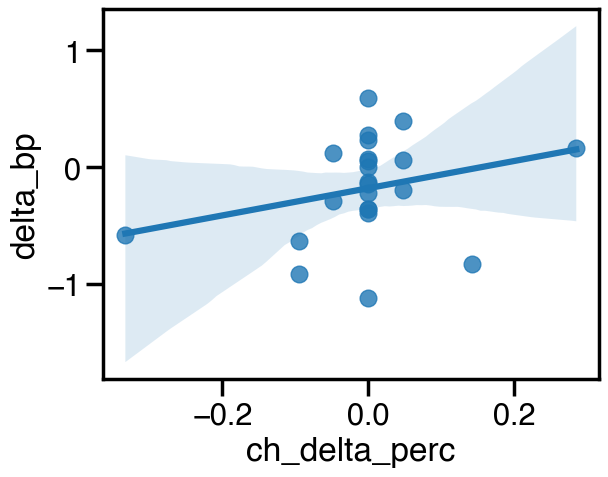

In [110]:
sns.regplot(diff_df_mean_wperc['ch_delta_perc'], diff_df_mean_wperc['delta_bp'])